In [1]:
#!pip install tensorflow==1.15
!pip install tensorflow-gpu==1.15

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras.layers import Input, Lambda, Dense, Dropout
from keras.models import Model
import keras.backend as K
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import os.path as path_

import os

Using TensorFlow backend.


In [23]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
start_epoch = 0
epoch_iterator = start_epoch
number_of_epochs_to_fit = 25
batch_size = 32
model_id = '0'
dropout_rate = 0.4
lr = 0.0001
reg = 0.001

In [0]:
elmo_embeder = hub.Module("https://tfhub.dev/google/elmo/3", trainable=False)

In [29]:
dataset = pd.read_csv("../Dataset/train_dataset.csv", encoding='utf-8')
test_data = pd.read_csv('../Dataset/test_dataset.csv', encoding='utf-8')

# deviding train and validation set
size = dataset.shape[0]
train_size = int((size*95)/100)
train_data = dataset.iloc[0:train_size]
validation_data = dataset.iloc[train_size:]


y_train = list(train_data['sentiment'])
X_train = list(train_data['content'])

y_val = list(validation_data['sentiment'])
X_val = list(validation_data['content'])

y_test = list(test_data['sentiment'])
X_test = list(test_data['content'])

le = preprocessing.LabelEncoder()
le.fit(y_train)

def encode(labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

y_train_one_hot = encode(y_train)
y_val_one_hot = encode(y_val)
y_test_one_hot = encode(y_test)

X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train_one_hot)
y_val = np.asarray(y_val_one_hot)
y_test = np.asarray(y_test_one_hot)

print(X_train.shape[0])
print(X_val.shape[0])
print(X_test.shape[0])

def ELMoEmbedding(x):
    return elmo_embeder(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]


48640
2560
12800


In [30]:
# Model

input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg))(embedding)
do = Dropout(dropout_rate)(dense)
dense = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg))(do)
do = Dropout(dropout_rate)(dense)
dense = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg))(do)
do = Dropout(dropout_rate)(dense)
dense = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg))(do)
do = Dropout(dropout_rate)(dense)
dense = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg))(do)
pred = Dense(8, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr), metrics=['accuracy'])
print(model.summary())

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               2626

In [21]:
# Train


with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    if(epoch_iterator > 0):
        model.load_weights('elmo-'+model_id+'-epoch-'+str(epoch_iterator)+'.h5')
    for i in range(number_of_epochs_to_fit):
        history = model.fit(X_train, y_train, initial_epoch=epoch_iterator, epochs=epoch_iterator+1, batch_size=32, verbose=1, validation_data=(X_val, y_val))
        epoch_iterator += 1
        model.save_weights('elmo-'+model_id+'-epoch-'+str(epoch_iterator)+'.h5')
        
        
        # Save logs
        logs = pd.DataFrame(columns=["epoch_num", "train_accuracy", "val_accuracy", "train_loss", "val_loss"])
        logs = logs.append({"epoch_num":epoch_iterator, "train_accuracy":history.history['accuracy'][0], "val_accuracy":history.history['val_accuracy'][0] , "train_loss":history.history['loss'][0] , "val_loss":history.history['val_loss'][0] }, ignore_index = True)
        if path_.isfile('logs-'+model_id+'.csv'):
            logs.to_csv('logs-'+model_id+'.csv', index=False, mode='a', header=False, encoding="utf-8")
        else:
            logs.to_csv('logs-'+model_id+'.csv', index=False, mode='a', header=True, encoding="utf-8")

    

Train on 48640 samples, validate on 2560 samples
Epoch 1/1
48640/48640 [==============================] - 472s 10ms/step - loss: 3.6516 - accuracy: 0.2049 - val_loss: 3.1177 - val_accuracy: 0.2680
Train on 48640 samples, validate on 2560 samples
Epoch 2/2
48640/48640 [==============================] - 470s 10ms/step - loss: 2.8719 - accuracy: 0.2860 - val_loss: 2.6204 - val_accuracy: 0.3262
Train on 48640 samples, validate on 2560 samples
Epoch 3/3
48640/48640 [==============================] - 470s 10ms/step - loss: 2.4816 - accuracy: 0.3252 - val_loss: 2.3414 - val_accuracy: 0.3434
Train on 48640 samples, validate on 2560 samples
Epoch 4/4
48640/48640 [==============================] - 468s 10ms/step - loss: 2.2389 - accuracy: 0.3578 - val_loss: 2.1468 - val_accuracy: 0.3684
Train on 48640 samples, validate on 2560 samples
Epoch 5/5
48640/48640 [==============================] - 469s 10ms/step - loss: 2.0730 - accuracy: 0.3895 - val_loss: 2.0288 - val_accuracy: 0.3914
Train on 48640 

KeyboardInterrupt: ignored

In [0]:
# Predict test data


with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('elmo-'+model_id+'-epoch-'+str(epoch_iterator)+'.h5')  
    predicts = model.predict(X_test, batch_size=32)

y_test = decode(y_test)
y_preds = decode(predicts)

In [32]:
# Print results


print(metrics.confusion_matrix(y_test, y_preds))

print(metrics.classification_report(y_test, y_preds))

print(accuracy_score(y_test, y_preds))

[[1312   10   12    2    2   10    9   10]
 [  38  815   64  341   60  149  244  100]
 [  18   19 1279   27    0   29   18    9]
 [  20  262   56  917   45  146  175  116]
 [   0   42    1   52 1289    6    3   11]
 [  76  231  130  311   28  604  194  229]
 [  16  180   27  191    7   61  902   45]
 [  81  222   97  428   36  370  196  420]]
              precision    recall  f1-score   support

       anger       0.84      0.96      0.90      1367
   happiness       0.46      0.45      0.45      1811
        hate       0.77      0.91      0.83      1399
     neutral       0.40      0.53      0.46      1737
      relief       0.88      0.92      0.90      1404
     sadness       0.44      0.33      0.38      1803
    surprise       0.52      0.63      0.57      1429
       worry       0.45      0.23      0.30      1850

    accuracy                           0.59     12800
   macro avg       0.59      0.62      0.60     12800
weighted avg       0.57      0.59      0.57     12800

0.58

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 <a list of 7 Text major ticklabel objects>)

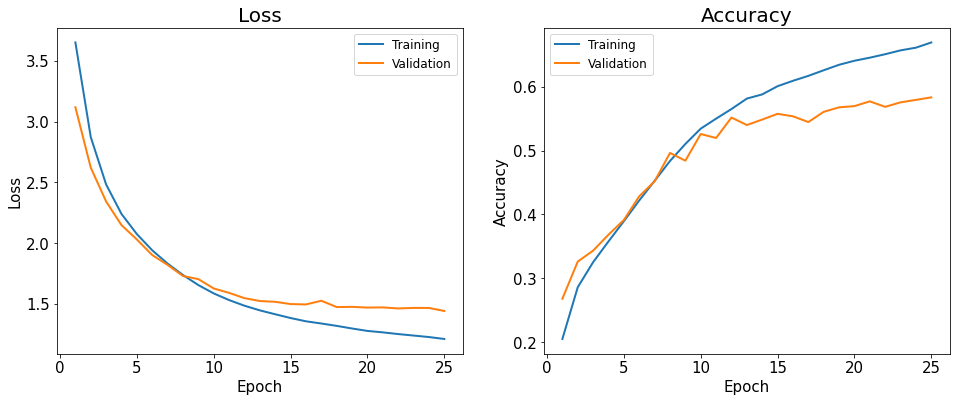

In [4]:
# Plot results

logs_ = pd.read_csv('logs-'+model_id+'.csv', encoding="utf-8")

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(logs_['epoch_num'], logs_['train_loss'], linewidth=2)
plt.plot(logs_['epoch_num'], logs_['val_loss'], linewidth=2)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(['Training', 'Validation'], fontsize=12)
plt.title('Loss', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(logs_['epoch_num'], logs_['train_accuracy'], linewidth=2)
plt.plot(logs_['epoch_num'], logs_['val_accuracy'], linewidth=2)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(['Training', 'Validation'], fontsize=12)
plt.title('Accuracy', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
